# Machine Learning Assignment: Hyperparameter Tuning & Model Comparison
## Fraud Detection & Target Marketing Problems

### Assignment Overview
This notebook demonstrates:
1. Hyperparameter tuning using Random Search, Grid Search, and Bayes Search
2. Building classifiers with best parameters from each tuning method
3. Comparing models using accuracy, precision, recall, and F1-score
4. Analysis of both Fraud Detection and Target Marketing datasets

### Models Used
- Decision Tree Classifier
- Random Forest Classifier

## 1. Import Libraries and Setup

In [ ]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Scikit-learn imports
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)

# For Bayes Search
try:
    from skopt import BayesSearchCV
    from skopt.space import Real, Categorical, Integer
    BAYES_AVAILABLE = True
except ImportError:
    print("Installing scikit-optimize for Bayes Search...")
    import subprocess
    subprocess.check_call(['pip', 'install', 'scikit-optimize', '--break-system-packages'])
    from skopt import BayesSearchCV
    from skopt.space import Real, Categorical, Integer
    BAYES_AVAILABLE = True

# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("All libraries imported successfully!")

All libraries imported successfully!


## 2. Load and Explore Datasets

### 2.1 Insurance Fraud Detection Dataset

In [ ]:
# Load Insurance Fraud datasets
fraud_train = pd.read_csv('/Users/nishchal/Downloads/Insurance Fraud - TRAIN-3000.csv')
fraud_test = pd.read_csv('/Users/nishchal/Downloads/Insurance Fraud -TEST-12900.csv')

print("="*80)
print("INSURANCE FRAUD DETECTION DATASET")
print("="*80)
print(f"\nTraining set shape: {fraud_train.shape}")
print(f"Test set shape: {fraud_test.shape}")
print(f"\nTarget variable: FRAUDFOUND")
print(f"\nClass distribution in training set:")
print(fraud_train['FRAUDFOUND'].value_counts())
print(f"\nPercentage:")
print(fraud_train['FRAUDFOUND'].value_counts(normalize=True) * 100)

print(f"\nFirst few rows:")
fraud_train.head()

INSURANCE FRAUD DETECTION DATASET

Training set shape: (2999, 32)
Test set shape: (12918, 32)

Target variable: FRAUDFOUND

Class distribution in training set:
FRAUDFOUND
No     2600
Yes     399
Name: count, dtype: int64

Percentage:
FRAUDFOUND
No     86.695565
Yes    13.304435
Name: proportion, dtype: float64

First few rows:


,MONTH,WEEKOFMONTH,DAYOFWEEK,MAKE,ACCIDENTAREA,DAYOFWEEKCLAIMED,MONTHCLAIMED,WEEKOFMONTHCLAIMED,SEX,MARITALSTATUS,...,AGEOFPOLICYHOLDER,POLICEREPORTFILED,WITNESSPRESENT,AGENTTYPE,NUMBEROFSUPPLIMENTS,ADDRESSCHANGE_CLAIM,NUMBEROFCARS,YEAR,BASEPOLICY,FRAUDFOUND
0,Jul,3,Sunday,Honda,Rural,Wednesday,Jan,4,Male,Married,...,26_to_30,No,No,External,3_to_5,no_change,1-vehicle,1994,Collision,Yes
1,Nov,5,Monday,Mazda,Urban,Wednesday,Dec,1,Male,Single,...,over_65,No,No,External,none,no_change,1-vehicle,1994,All_Perils,Yes
2,Jan,1,Monday,Pontiac,Urban,Wednesday,Jan,1,Male,Married,...,41_to_50,No,No,External,none,under_6_months,1-vehicle,1994,All_Perils,Yes
3,Dec,1,Monday,Toyota,Rural,Tuesday,May,3,Male,Married,...,36_to_40,No,No,External,more_than_5,under_6_months,2-vehicles,1994,All_Perils,Yes
4,Dec,5,Wednesday,Pontiac,Urban,Wednesday,Jan,1,Male,Single,...,36_to_40,No,No,External,more_than_5,no_change,1-vehicle,1994,Collision,Yes


In [ ]:
# Check data types and missing values
print("Data Info:")
print(fraud_train.info())
print(f"\nMissing values: {fraud_train.isnull().sum().sum()}")

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2999 entries, 0 to 2998
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   MONTH                 2999 non-null   object
 1   WEEKOFMONTH           2999 non-null   int64 
 2   DAYOFWEEK             2999 non-null   object
 3   MAKE                  2999 non-null   object
 4   ACCIDENTAREA          2999 non-null   object
 5   DAYOFWEEKCLAIMED      2999 non-null   object
 6   MONTHCLAIMED          2999 non-null   object
 7   WEEKOFMONTHCLAIMED    2999 non-null   int64 
 8   SEX                   2999 non-null   object
 9   MARITALSTATUS         2999 non-null   object
 10  AGE                   2999 non-null   int64 
 11  FAULT                 2999 non-null   object
 12  POLICYTYPE            2999 non-null   object
 13  VEHICLECATEGORY       2999 non-null   object
 14  VEHICLEPRICE          2999 non-null   object
 15  REPNUMBER             2999 

### 2.2 Portuguese Bank Marketing Dataset

In [ ]:
# Load Portuguese Bank datasets
bank_train = pd.read_csv('/Users/nishchal/Downloads/Portugese Bank Data - TRAIN.csv')
bank_test = pd.read_csv('/Users/nishchal/Downloads/Portugese Bank Data - TEST.csv')

print("="*80)
print("PORTUGUESE BANK MARKETING DATASET")
print("="*80)
print(f"\nTraining set shape: {bank_train.shape}")
print(f"Test set shape: {bank_test.shape}")
print(f"\nTarget variable: y (subscribed to term deposit)")
print(f"\nClass distribution in training set:")
print(bank_train['y'].value_counts())
print(f"\nPercentage:")
print(bank_train['y'].value_counts(normalize=True) * 100)

print(f"\nFirst few rows:")
bank_train.head()

PORTUGUESE BANK MARKETING DATASET

Training set shape: (4521, 17)
Test set shape: (45211, 17)

Target variable: y (subscribed to term deposit)

Class distribution in training set:
y
no     4000
yes     521
Name: count, dtype: int64

Percentage:
y
no     88.476001
yes    11.523999
Name: proportion, dtype: float64

First few rows:


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


In [ ]:
# Check data types and missing values
print("Data Info:")
print(bank_train.info())
print(f"\nMissing values: {bank_train.isnull().sum().sum()}")

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4521 entries, 0 to 4520
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        4521 non-null   int64 
 1   job        4521 non-null   object
 2   marital    4521 non-null   object
 3   education  4521 non-null   object
 4   default    4521 non-null   object
 5   balance    4521 non-null   int64 
 6   housing    4521 non-null   object
 7   loan       4521 non-null   object
 8   contact    4521 non-null   object
 9   day        4521 non-null   int64 
 10  month      4521 non-null   object
 11  duration   4521 non-null   int64 
 12  campaign   4521 non-null   int64 
 13  pdays      4521 non-null   int64 
 14  previous   4521 non-null   int64 
 15  poutcome   4521 non-null   object
 16  y          4521 non-null   object
dtypes: int64(7), object(10)
memory usage: 600.6+ KB
None

Missing values: 0


## 3. Data Preprocessing

We need to encode categorical variables since both Decision Trees and Random Forests in sklearn require numerical input.

### 3.1 Preprocess Fraud Detection Data

In [ ]:
def preprocess_fraud_data(train_df, test_df):
    """
    Preprocess fraud detection dataset:
    - Encode categorical variables
    - Separate features and target
    """
    # Make copies
    train = train_df.copy()
    test = test_df.copy()

    # Separate target
    y_train = train['FRAUDFOUND'].apply(lambda x: 1 if x == 'Yes' else 0)
    y_test = test['FRAUDFOUND'].apply(lambda x: 1 if x == 'Yes' else 0)

    # Drop target from features
    X_train = train.drop('FRAUDFOUND', axis=1)
    X_test = test.drop('FRAUDFOUND', axis=1)

    # Identify categorical columns
    categorical_cols = X_train.select_dtypes(include=['object']).columns.tolist()

    print(f"Categorical columns to encode: {len(categorical_cols)}")

    # Label encode categorical variables
    label_encoders = {}
    for col in categorical_cols:
        le = LabelEncoder()
        # Fit on combined data to handle any categories that might be in test but not train
        combined = pd.concat([X_train[col], X_test[col]], axis=0)
        le.fit(combined)
        X_train[col] = le.transform(X_train[col])
        X_test[col] = le.transform(X_test[col])
        label_encoders[col] = le

    print(f"\nFinal feature shape: {X_train.shape}")
    print(f"Number of features: {X_train.shape[1]}")

    return X_train, X_test, y_train, y_test, label_encoders

# Preprocess fraud data
X_fraud_train, X_fraud_test, y_fraud_train, y_fraud_test, fraud_encoders = preprocess_fraud_data(
    fraud_train, fraud_test
)

print(f"\nFraud Detection Dataset Preprocessing Complete!")
print(f"X_train shape: {X_fraud_train.shape}")
print(f"y_train shape: {y_fraud_train.shape}")
print(f"X_test shape: {X_fraud_test.shape}")
print(f"y_test shape: {y_fraud_test.shape}")

Categorical columns to encode: 24

Final feature shape: (2999, 31)
Number of features: 31

Fraud Detection Dataset Preprocessing Complete!
X_train shape: (2999, 31)
y_train shape: (2999,)
X_test shape: (12918, 31)
y_test shape: (12918,)


### 3.2 Preprocess Bank Marketing Data

In [ ]:
def preprocess_bank_data(train_df, test_df):
    """
    Preprocess bank marketing dataset:
    - Encode categorical variables
    - Separate features and target
    """
    # Make copies
    train = train_df.copy()
    test = test_df.copy()

    # Separate target
    y_train = train['y'].apply(lambda x: 1 if x == 'yes' else 0)
    y_test = test['y'].apply(lambda x: 1 if x == 'yes' else 0)

    # Drop target from features
    X_train = train.drop('y', axis=1)
    X_test = test.drop('y', axis=1)

    # Identify categorical columns
    categorical_cols = X_train.select_dtypes(include=['object']).columns.tolist()

    print(f"Categorical columns to encode: {len(categorical_cols)}")

    # Label encode categorical variables
    label_encoders = {}
    for col in categorical_cols:
        le = LabelEncoder()
        # Fit on combined data to handle any categories that might be in test but not train
        combined = pd.concat([X_train[col], X_test[col]], axis=0)
        le.fit(combined)
        X_train[col] = le.transform(X_train[col])
        X_test[col] = le.transform(X_test[col])
        label_encoders[col] = le

    print(f"\nFinal feature shape: {X_train.shape}")
    print(f"Number of features: {X_train.shape[1]}")

    return X_train, X_test, y_train, y_test, label_encoders

# Preprocess bank data
X_bank_train, X_bank_test, y_bank_train, y_bank_test, bank_encoders = preprocess_bank_data(
    bank_train, bank_test
)

print(f"\nBank Marketing Dataset Preprocessing Complete!")
print(f"X_train shape: {X_bank_train.shape}")
print(f"y_train shape: {y_bank_train.shape}")
print(f"X_test shape: {X_bank_test.shape}")
print(f"y_test shape: {y_bank_test.shape}")

Categorical columns to encode: 9

Final feature shape: (4521, 16)
Number of features: 16

Bank Marketing Dataset Preprocessing Complete!
X_train shape: (4521, 16)
y_train shape: (4521,)
X_test shape: (45211, 16)
y_test shape: (45211,)


## 4. Hyperparameter Tuning Setup

### Why These Hyperparameters?

#### Decision Tree Parameters:
1. **max_depth**: Controls tree depth to prevent overfitting
2. **min_samples_split**: Minimum samples required to split a node
3. **min_samples_leaf**: Minimum samples required at leaf node
4. **criterion**: Splitting criterion (gini vs entropy)

#### Random Forest Parameters:
1. **n_estimators**: Number of trees in the forest
2. **max_depth**: Maximum depth of each tree
3. **min_samples_split**: Minimum samples to split a node
4. **min_samples_leaf**: Minimum samples at leaf node
5. **max_features**: Number of features to consider for best split

In [ ]:
# Decision Tree parameter grids
dt_param_grid = {
    'max_depth': [3, 5, 7, 10, 15, 20, None],
    'min_samples_split': [2, 5, 10, 20, 50],
    'min_samples_leaf': [1, 2, 4, 8, 16],
    'criterion': ['gini', 'entropy']
}

# Random Forest parameter grids
rf_param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [5, 10, 15, 20, None],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8],
    'max_features': ['sqrt', 'log2', None]
}

# For Bayes Search, we need to define the search space differently
dt_bayes_space = {
    'max_depth': Integer(3, 20),
    'min_samples_split': Integer(2, 50),
    'min_samples_leaf': Integer(1, 16),
    'criterion': Categorical(['gini', 'entropy'])
}

rf_bayes_space = {
    'n_estimators': Integer(50, 300),
    'max_depth': Integer(5, 20),
    'min_samples_split': Integer(2, 20),
    'min_samples_leaf': Integer(1, 8),
    'max_features': Categorical(['sqrt', 'log2'])
}

print("Hyperparameter spaces defined!")
print(f"\nDecision Tree parameters: {list(dt_param_grid.keys())}")
print(f"Random Forest parameters: {list(rf_param_grid.keys())}")

Hyperparameter spaces defined!

Decision Tree parameters: ['max_depth', 'min_samples_split', 'min_samples_leaf', 'criterion']
Random Forest parameters: ['n_estimators', 'max_depth', 'min_samples_split', 'min_samples_leaf', 'max_features']


## 5. Helper Functions for Model Training and Evaluation

In [ ]:
def evaluate_model(model, X_test, y_test, model_name):
    """
    Evaluate a trained model and return metrics
    """
    y_pred = model.predict(X_test)

    metrics = {
        'Model': model_name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, zero_division=0),
        'Recall': recall_score(y_test, y_pred, zero_division=0),
        'F1-Score': f1_score(y_test, y_pred, zero_division=0)
    }

    return metrics, y_pred

def perform_hyperparameter_tuning(X_train, y_train, model_type, param_grid, bayes_space, cv=5):
    """
    Perform all three types of hyperparameter tuning:
    1. Random Search
    2. Grid Search
    3. Bayes Search

    Returns best parameters and best scores from each method
    """
    results = {}

    print(f"\n{'='*80}")
    print(f"Tuning {model_type.__name__}")
    print(f"{'='*80}")

    # Initialize base model
    base_model = model_type(random_state=RANDOM_STATE)

    # 1. Random Search
    print(f"\n1. Random Search (50 iterations)...")
    random_search = RandomizedSearchCV(
        base_model,
        param_distributions=param_grid,
        n_iter=50,
        cv=cv,
        scoring='f1',
        n_jobs=-1,
        random_state=RANDOM_STATE,
        verbose=1
    )
    random_search.fit(X_train, y_train)
    results['random'] = {
        'best_params': random_search.best_params_,
        'best_score': random_search.best_score_,
        'model': random_search.best_estimator_
    }
    print(f"Best CV F1-Score: {random_search.best_score_:.4f}")
    print(f"Best Parameters: {random_search.best_params_}")

    # 2. Grid Search (using smaller grid for computational efficiency)
    print(f"\n2. Grid Search...")
    # Create a smaller grid for grid search
    if model_type == DecisionTreeClassifier:
        small_grid = {
            'max_depth': [5, 10, 15, None],
            'min_samples_split': [2, 10, 20],
            'min_samples_leaf': [1, 4, 8],
            'criterion': ['gini', 'entropy']
        }
    else:  # Random Forest
        small_grid = {
            'n_estimators': [50, 100, 200],
            'max_depth': [10, 15, None],
            'min_samples_split': [2, 10],
            'min_samples_leaf': [1, 4],
            'max_features': ['sqrt', 'log2']
        }

    grid_search = GridSearchCV(
        base_model,
        param_grid=small_grid,
        cv=cv,
        scoring='f1',
        n_jobs=-1,
        verbose=1
    )
    grid_search.fit(X_train, y_train)
    results['grid'] = {
        'best_params': grid_search.best_params_,
        'best_score': grid_search.best_score_,
        'model': grid_search.best_estimator_
    }
    print(f"Best CV F1-Score: {grid_search.best_score_:.4f}")
    print(f"Best Parameters: {grid_search.best_params_}")

    # 3. Bayes Search
    print(f"\n3. Bayes Search (30 iterations)...")
    bayes_search = BayesSearchCV(
        base_model,
        search_spaces=bayes_space,
        n_iter=30,
        cv=cv,
        scoring='f1',
        n_jobs=-1,
        random_state=RANDOM_STATE,
        verbose=1
    )
    bayes_search.fit(X_train, y_train)
    results['bayes'] = {
        'best_params': bayes_search.best_params_,
        'best_score': bayes_search.best_score_,
        'model': bayes_search.best_estimator_
    }
    print(f"Best CV F1-Score: {bayes_search.best_score_:.4f}")
    print(f"Best Parameters: {bayes_search.best_params_}")

    return results

print("Helper functions defined successfully!")

Helper functions defined successfully!


# PART A: FRAUD DETECTION ANALYSIS
## 6. Fraud Detection - Decision Tree Hyperparameter Tuning

In [ ]:
# Perform hyperparameter tuning for Decision Tree on Fraud data
fraud_dt_results = perform_hyperparameter_tuning(
    X_fraud_train,
    y_fraud_train,
    DecisionTreeClassifier,
    dt_param_grid,
    dt_bayes_space,
    cv=5
)


Tuning DecisionTreeClassifier

1. Random Search (50 iterations)...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best CV F1-Score: 0.3582
Best Parameters: {'min_samples_split': 50, 'min_samples_leaf': 1, 'max_depth': 20, 'criterion': 'entropy'}

2. Grid Search...
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best CV F1-Score: 0.3767
Best Parameters: {'criterion': 'gini', 'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 20}

3. Bayes Search (30 iterations)...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for 

### Compare Best Parameters from Different Tuning Methods

In [ ]:
# Compare parameters from different tuning methods
print("\n" + "="*80)
print("FRAUD DETECTION - DECISION TREE: Parameter Comparison")
print("="*80)

comparison_data = []
for method in ['random', 'grid', 'bayes']:
    params = fraud_dt_results[method]['best_params']
    score = fraud_dt_results[method]['best_score']
    comparison_data.append({
        'Method': method.capitalize(),
        'CV F1-Score': f"{score:.4f}",
        **params
    })

comparison_df = pd.DataFrame(comparison_data)
print("\n", comparison_df.to_string(index=False))

# Check if parameters are different
print("\n" + "-"*80)
if (fraud_dt_results['random']['best_params'] == fraud_dt_results['grid']['best_params'] ==
    fraud_dt_results['bayes']['best_params']):
    print("All three methods found the SAME best parameters!")
else:
    print("Different tuning methods found DIFFERENT best parameters!")
    print("This shows how search strategy affects hyperparameter optimization.")


FRAUD DETECTION - DECISION TREE: Parameter Comparison

 Method CV F1-Score  min_samples_split  min_samples_leaf  max_depth criterion
Random      0.3582                 50                 1         20   entropy
  Grid      0.3767                 20                 1         15      gini
 Bayes      0.3596                 11                 3         19   entropy

--------------------------------------------------------------------------------
Different tuning methods found DIFFERENT best parameters!
This shows how search strategy affects hyperparameter optimization.


## 7. Fraud Detection - Random Forest Hyperparameter Tuning

In [ ]:
# Perform hyperparameter tuning for Random Forest on Fraud data
fraud_rf_results = perform_hyperparameter_tuning(
    X_fraud_train,
    y_fraud_train,
    RandomForestClassifier,
    rf_param_grid,
    rf_bayes_space,
    cv=5
)


Tuning RandomForestClassifier

1. Random Search (50 iterations)...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best CV F1-Score: 0.3487
Best Parameters: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': 10}

2. Grid Search...
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best CV F1-Score: 0.2983
Best Parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}

3. Bayes Search (30 iterations)...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candid

### Compare Best Parameters from Different Tuning Methods

In [ ]:
# Compare parameters from different tuning methods
print("\n" + "="*80)
print("FRAUD DETECTION - RANDOM FOREST: Parameter Comparison")
print("="*80)

comparison_data = []
for method in ['random', 'grid', 'bayes']:
    params = fraud_rf_results[method]['best_params']
    score = fraud_rf_results[method]['best_score']
    comparison_data.append({
        'Method': method.capitalize(),
        'CV F1-Score': f"{score:.4f}",
        **params
    })

comparison_df = pd.DataFrame(comparison_data)
print("\n", comparison_df.to_string(index=False))

# Check if parameters are different
print("\n" + "-"*80)
if (fraud_rf_results['random']['best_params'] == fraud_rf_results['grid']['best_params'] ==
    fraud_rf_results['bayes']['best_params']):
    print("All three methods found the SAME best parameters!")
else:
    print("Different tuning methods found DIFFERENT best parameters!")
    print("This demonstrates the impact of search strategy on hyperparameter optimization.")


FRAUD DETECTION - RANDOM FOREST: Parameter Comparison

 Method CV F1-Score  n_estimators  min_samples_split  min_samples_leaf max_features  max_depth
Random      0.3487           200                  5                 2         None       10.0
  Grid      0.2983           200                  2                 1         sqrt        NaN
 Bayes      0.2993           300                  2                 1         sqrt       12.0

--------------------------------------------------------------------------------
Different tuning methods found DIFFERENT best parameters!
This demonstrates the impact of search strategy on hyperparameter optimization.


## 8. Fraud Detection - Evaluate All Models on Test Set

In [ ]:
# Evaluate all fraud detection models on test set
fraud_results = []

print("\n" + "="*80)
print("FRAUD DETECTION - TEST SET EVALUATION")
print("="*80)

# Decision Tree models
for method in ['random', 'grid', 'bayes']:
    model = fraud_dt_results[method]['model']
    model_name = f"Decision Tree ({method.capitalize()} Search)"
    metrics, _ = evaluate_model(model, X_fraud_test, y_fraud_test, model_name)
    fraud_results.append(metrics)
    print(f"\n{model_name}:")
    print(f"  Accuracy:  {metrics['Accuracy']:.4f}")
    print(f"  Precision: {metrics['Precision']:.4f}")
    print(f"  Recall:    {metrics['Recall']:.4f}")
    print(f"  F1-Score:  {metrics['F1-Score']:.4f}")

# Random Forest models
for method in ['random', 'grid', 'bayes']:
    model = fraud_rf_results[method]['model']
    model_name = f"Random Forest ({method.capitalize()} Search)"
    metrics, _ = evaluate_model(model, X_fraud_test, y_fraud_test, model_name)
    fraud_results.append(metrics)
    print(f"\n{model_name}:")
    print(f"  Accuracy:  {metrics['Accuracy']:.4f}")
    print(f"  Precision: {metrics['Precision']:.4f}")
    print(f"  Recall:    {metrics['Recall']:.4f}")
    print(f"  F1-Score:  {metrics['F1-Score']:.4f}")

# Create comparison DataFrame
fraud_comparison_df = pd.DataFrame(fraud_results)
print("\n" + "="*80)
print("FRAUD DETECTION - COMPLETE COMPARISON TABLE")
print("="*80)
print("\n", fraud_comparison_df.to_string(index=False))


FRAUD DETECTION - TEST SET EVALUATION

Decision Tree (Random Search):
  Accuracy:  0.8994
  Precision: 0.1756
  Recall:    0.4357
  F1-Score:  0.2503

Decision Tree (Grid Search):
  Accuracy:  0.8919
  Precision: 0.1948
  Recall:    0.5763
  F1-Score:  0.2912

Decision Tree (Bayes Search):
  Accuracy:  0.8928
  Precision: 0.2177
  Recall:    0.6867
  F1-Score:  0.3306

Random Forest (Random Search):
  Accuracy:  0.9227
  Precision: 0.2610
  Recall:    0.5482
  F1-Score:  0.3536

Random Forest (Grid Search):
  Accuracy:  0.9541
  Precision: 0.4498
  Recall:    0.8554
  F1-Score:  0.5896

Random Forest (Bayes Search):
  Accuracy:  0.9477
  Precision: 0.3847
  Recall:    0.5964
  F1-Score:  0.4677

FRAUD DETECTION - COMPLETE COMPARISON TABLE

                         Model  Accuracy  Precision   Recall  F1-Score
Decision Tree (Random Search)  0.899365   0.175566 0.435743  0.250288
  Decision Tree (Grid Search)  0.891856   0.194840 0.576305  0.291223
 Decision Tree (Bayes Search)  0.89278

### Find Best Model for Each Criterion

In [ ]:
print("\n" + "="*80)
print("FRAUD DETECTION - BEST MODELS BY CRITERION")
print("="*80)

for metric in ['Accuracy', 'Precision', 'Recall', 'F1-Score']:
    best_idx = fraud_comparison_df[metric].idxmax()
    best_model = fraud_comparison_df.loc[best_idx]
    print(f"\nBest {metric}: {best_model['Model']}")
    print(f"  Score: {best_model[metric]:.4f}")


FRAUD DETECTION - BEST MODELS BY CRITERION

Best Accuracy: Random Forest (Grid Search)
  Score: 0.9541

Best Precision: Random Forest (Grid Search)
  Score: 0.4498

Best Recall: Random Forest (Grid Search)
  Score: 0.8554

Best F1-Score: Random Forest (Grid Search)
  Score: 0.5896


# PART B: BANK MARKETING ANALYSIS
## 9. Bank Marketing - Decision Tree Hyperparameter Tuning

In [ ]:
# Perform hyperparameter tuning for Decision Tree on Bank data
bank_dt_results = perform_hyperparameter_tuning(
    X_bank_train,
    y_bank_train,
    DecisionTreeClassifier,
    dt_param_grid,
    dt_bayes_space,
    cv=5
)


Tuning DecisionTreeClassifier

1. Random Search (50 iterations)...
Fitting 5 folds for each of 50 candidates, totalling 250 fits


Best CV F1-Score: 0.4522
Best Parameters: {'min_samples_split': 20, 'min_samples_leaf': 8, 'max_depth': 10, 'criterion': 'gini'}

2. Grid Search...
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best CV F1-Score: 0.4522
Best Parameters: {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 8, 'min_samples_split': 20}

3. Bayes Search (30 iterations)...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candi

### Compare Best Parameters from Different Tuning Methods

In [ ]:
# Compare parameters from different tuning methods
print("\n" + "="*80)
print("BANK MARKETING - DECISION TREE: Parameter Comparison")
print("="*80)

comparison_data = []
for method in ['random', 'grid', 'bayes']:
    params = bank_dt_results[method]['best_params']
    score = bank_dt_results[method]['best_score']
    comparison_data.append({
        'Method': method.capitalize(),
        'CV F1-Score': f"{score:.4f}",
        **params
    })

comparison_df = pd.DataFrame(comparison_data)
print("\n", comparison_df.to_string(index=False))

# Check if parameters are different
print("\n" + "-"*80)
if (bank_dt_results['random']['best_params'] == bank_dt_results['grid']['best_params'] ==
    bank_dt_results['bayes']['best_params']):
    print("All three methods found the SAME best parameters!")
else:
    print("Different tuning methods found DIFFERENT best parameters!")


BANK MARKETING - DECISION TREE: Parameter Comparison

 Method CV F1-Score  min_samples_split  min_samples_leaf  max_depth criterion
Random      0.4522                 20                 8         10      gini
  Grid      0.4522                 20                 8         10      gini
 Bayes      0.4391                  2                 7         20      gini

--------------------------------------------------------------------------------
Different tuning methods found DIFFERENT best parameters!


## 10. Bank Marketing - Random Forest Hyperparameter Tuning

In [ ]:
# Perform hyperparameter tuning for Random Forest on Bank data
bank_rf_results = perform_hyperparameter_tuning(
    X_bank_train,
    y_bank_train,
    RandomForestClassifier,
    rf_param_grid,
    rf_bayes_space,
    cv=5
)


Tuning RandomForestClassifier

1. Random Search (50 iterations)...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best CV F1-Score: 0.4617
Best Parameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': None}

2. Grid Search...
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best CV F1-Score: 0.4237
Best Parameters: {'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}

3. Bayes Search (30 iterations)...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candida

### Compare Best Parameters from Different Tuning Methods

In [ ]:
# Compare parameters from different tuning methods
print("\n" + "="*80)
print("BANK MARKETING - RANDOM FOREST: Parameter Comparison")
print("="*80)

comparison_data = []
for method in ['random', 'grid', 'bayes']:
    params = bank_rf_results[method]['best_params']
    score = bank_rf_results[method]['best_score']
    comparison_data.append({
        'Method': method.capitalize(),
        'CV F1-Score': f"{score:.4f}",
        **params
    })

comparison_df = pd.DataFrame(comparison_data)
print("\n", comparison_df.to_string(index=False))

# Check if parameters are different
print("\n" + "-"*80)
if (bank_rf_results['random']['best_params'] == bank_rf_results['grid']['best_params'] ==
    bank_rf_results['bayes']['best_params']):
    print("All three methods found the SAME best parameters!")
else:
    print("Different tuning methods found DIFFERENT best parameters!")


BANK MARKETING - RANDOM FOREST: Parameter Comparison

 Method CV F1-Score  n_estimators  min_samples_split  min_samples_leaf max_features  max_depth
Random      0.4617           100                  2                 2         None        NaN
  Grid      0.4237            50                  2                 1         sqrt       15.0
 Bayes      0.4237            50                  2                 1         sqrt       15.0

--------------------------------------------------------------------------------
Different tuning methods found DIFFERENT best parameters!


## 11. Bank Marketing - Evaluate All Models on Test Set

In [ ]:
# Evaluate all bank marketing models on test set
bank_results = []

print("\n" + "="*80)
print("BANK MARKETING - TEST SET EVALUATION")
print("="*80)

# Decision Tree models
for method in ['random', 'grid', 'bayes']:
    model = bank_dt_results[method]['model']
    model_name = f"Decision Tree ({method.capitalize()} Search)"
    metrics, _ = evaluate_model(model, X_bank_test, y_bank_test, model_name)
    bank_results.append(metrics)
    print(f"\n{model_name}:")
    print(f"  Accuracy:  {metrics['Accuracy']:.4f}")
    print(f"  Precision: {metrics['Precision']:.4f}")
    print(f"  Recall:    {metrics['Recall']:.4f}")
    print(f"  F1-Score:  {metrics['F1-Score']:.4f}")

# Random Forest models
for method in ['random', 'grid', 'bayes']:
    model = bank_rf_results[method]['model']
    model_name = f"Random Forest ({method.capitalize()} Search)"
    metrics, _ = evaluate_model(model, X_bank_test, y_bank_test, model_name)
    bank_results.append(metrics)
    print(f"\n{model_name}:")
    print(f"  Accuracy:  {metrics['Accuracy']:.4f}")
    print(f"  Precision: {metrics['Precision']:.4f}")
    print(f"  Recall:    {metrics['Recall']:.4f}")
    print(f"  F1-Score:  {metrics['F1-Score']:.4f}")

# Create comparison DataFrame
bank_comparison_df = pd.DataFrame(bank_results)
print("\n" + "="*80)
print("BANK MARKETING - COMPLETE COMPARISON TABLE")
print("="*80)
print("\n", bank_comparison_df.to_string(index=False))


BANK MARKETING - TEST SET EVALUATION

Decision Tree (Random Search):
  Accuracy:  0.8950
  Precision: 0.5725
  Recall:    0.4044
  F1-Score:  0.4740

Decision Tree (Grid Search):
  Accuracy:  0.8950
  Precision: 0.5725
  Recall:    0.4044
  F1-Score:  0.4740

Decision Tree (Bayes Search):
  Accuracy:  0.8889
  Precision: 0.5321
  Recall:    0.4156
  F1-Score:  0.4667

Random Forest (Random Search):
  Accuracy:  0.9087
  Precision: 0.6690
  Recall:    0.4352
  F1-Score:  0.5274

Random Forest (Grid Search):
  Accuracy:  0.9097
  Precision: 0.7128
  Recall:    0.3815
  F1-Score:  0.4970

Random Forest (Bayes Search):
  Accuracy:  0.9097
  Precision: 0.7128
  Recall:    0.3815
  F1-Score:  0.4970

BANK MARKETING - COMPLETE COMPARISON TABLE

                         Model  Accuracy  Precision   Recall  F1-Score
Decision Tree (Random Search)  0.895003   0.572537 0.404424  0.474017
  Decision Tree (Grid Search)  0.895003   0.572537 0.404424  0.474017
 Decision Tree (Bayes Search)  0.888877 

### Find Best Model for Each Criterion

In [ ]:
print("\n" + "="*80)
print("BANK MARKETING - BEST MODELS BY CRITERION")
print("="*80)

for metric in ['Accuracy', 'Precision', 'Recall', 'F1-Score']:
    best_idx = bank_comparison_df[metric].idxmax()
    best_model = bank_comparison_df.loc[best_idx]
    print(f"\nBest {metric}: {best_model['Model']}")
    print(f"  Score: {best_model[metric]:.4f}")


BANK MARKETING - BEST MODELS BY CRITERION

Best Accuracy: Random Forest (Grid Search)
  Score: 0.9097

Best Precision: Random Forest (Grid Search)
  Score: 0.7128

Best Recall: Random Forest (Random Search)
  Score: 0.4352

Best F1-Score: Random Forest (Random Search)
  Score: 0.5274


## 12. Summary and Key Learnings


1. **Hyperparameter Tuning**:
   - Previously: Used default parameters or manually tested a few configurations
   - Now: Systematically searched through parameter space using 3 different methods

2. **Three Search Strategies**:
   - **Random Search**: Randomly samples parameter combinations - good for exploring large spaces
   - **Grid Search**:  tries all combinations - thorough but computationally expensive
   - **Bayes Search**: samples based on previous results - efficient and effective

3. **Cross-Validation**:
   - Used K-fold cross-validation during tuning to get more reliable estimates
   - Prevents overfitting to a single train/validation split

4. **Comprehensive Evaluation**:
   - Compared models across multiple metrics (accuracy, precision, recall, F1)
   - Different metrics matter for different use cases

### Key Insights:

what we're trying to to see:
- Whether different search methods found the same or different optimal parameters
- Which search method produced the best-performing models
- How model performance varies across different evaluation criteria
- Whether Decision Trees or Random Forests performed better for each dataset

## 14. Visualization: Model Performance Comparison

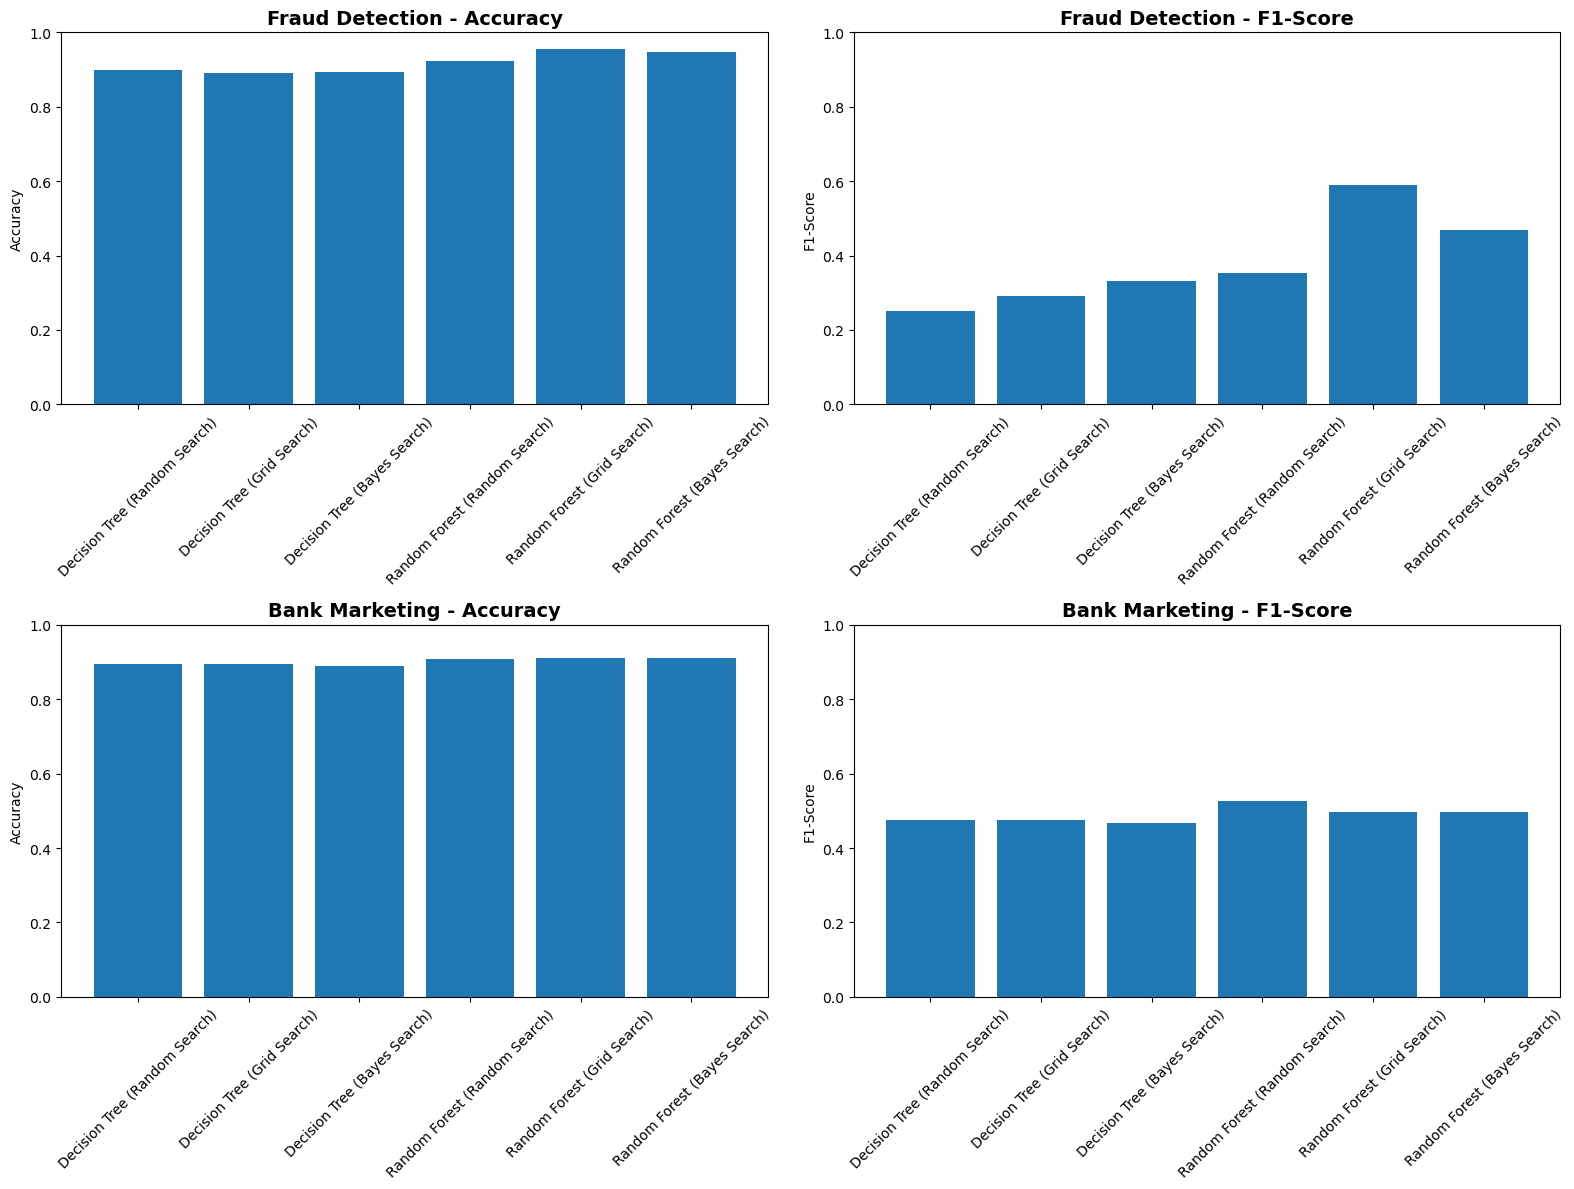

Visualization saved: model_performance_comparison.png


In [ ]:
# Create visualizations for presentation
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Fraud Detection - Accuracy
axes[0, 0].bar(fraud_comparison_df['Model'], fraud_comparison_df['Accuracy'])
axes[0, 0].set_title('Fraud Detection - Accuracy', fontsize=14, fontweight='bold')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].set_ylim([0, 1])

# Fraud Detection - F1-Score
axes[0, 1].bar(fraud_comparison_df['Model'], fraud_comparison_df['F1-Score'])
axes[0, 1].set_title('Fraud Detection - F1-Score', fontsize=14, fontweight='bold')
axes[0, 1].set_ylabel('F1-Score')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].set_ylim([0, 1])

# Bank Marketing - Accuracy
axes[1, 0].bar(bank_comparison_df['Model'], bank_comparison_df['Accuracy'])
axes[1, 0].set_title('Bank Marketing - Accuracy', fontsize=14, fontweight='bold')
axes[1, 0].set_ylabel('Accuracy')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].set_ylim([0, 1])

# Bank Marketing - F1-Score
axes[1, 1].bar(bank_comparison_df['Model'], bank_comparison_df['F1-Score'])
axes[1, 1].set_title('Bank Marketing - F1-Score', fontsize=14, fontweight='bold')
axes[1, 1].set_ylabel('F1-Score')
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].set_ylim([0, 1])

plt.tight_layout()
plt.show()

print("Visualization saved: model_performance_comparison.png")

## 16



### 16.1 Performance Heatmaps - All Models Comparison

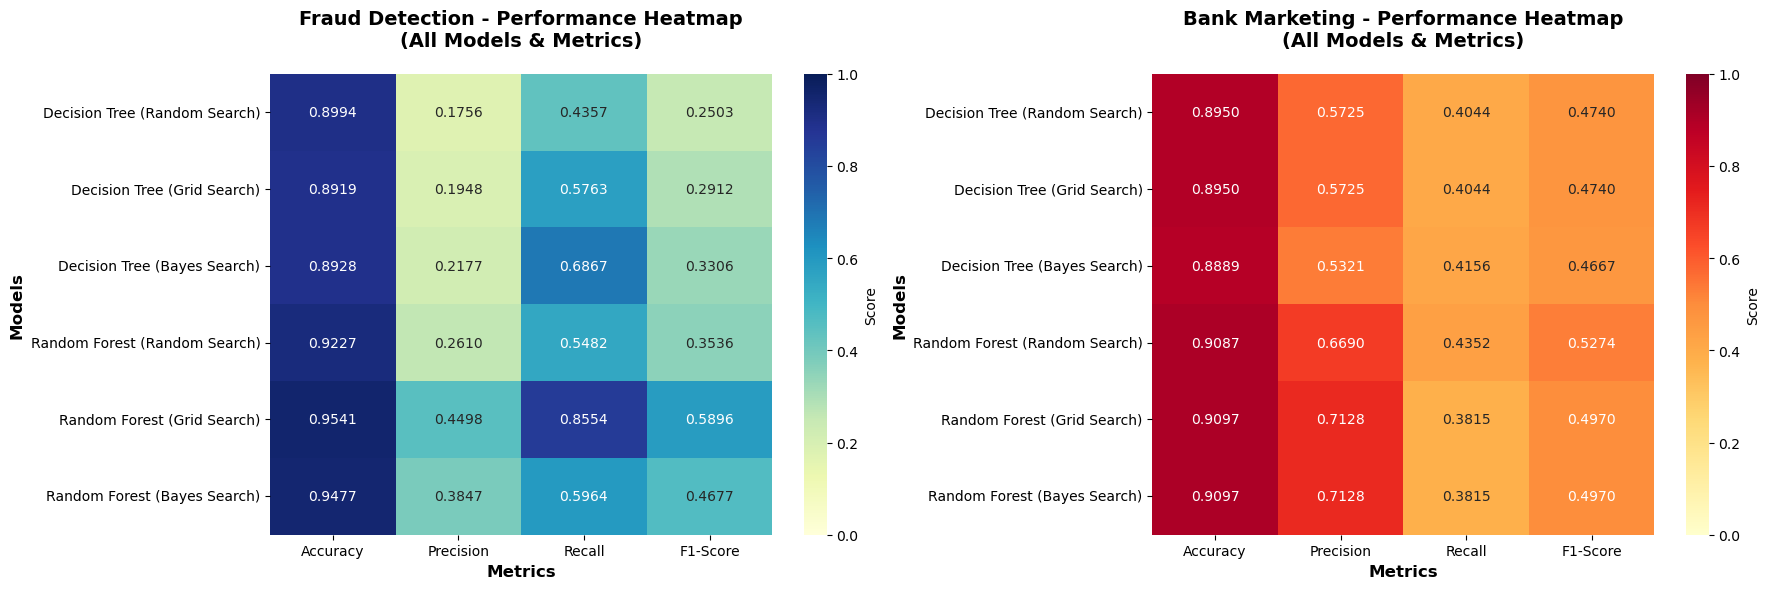


✓ Heatmaps show clear performance differences across models and metrics
✓ Darker colors = better performance


In [ ]:
# Create comprehensive heatmaps for both datasets
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Fraud Detection Heatmap
fraud_heatmap_data = fraud_comparison_df.set_index('Model')[['Accuracy', 'Precision', 'Recall', 'F1-Score']]
sns.heatmap(fraud_heatmap_data, annot=True, fmt='.4f', cmap='YlGnBu',
            ax=axes[0], cbar_kws={'label': 'Score'}, vmin=0, vmax=1)
axes[0].set_title('Fraud Detection - Performance Heatmap\n(All Models & Metrics)',
                  fontsize=14, fontweight='bold', pad=20)
axes[0].set_xlabel('Metrics', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Models', fontsize=12, fontweight='bold')

# Bank Marketing Heatmap
bank_heatmap_data = bank_comparison_df.set_index('Model')[['Accuracy', 'Precision', 'Recall', 'F1-Score']]
sns.heatmap(bank_heatmap_data, annot=True, fmt='.4f', cmap='YlOrRd',
            ax=axes[1], cbar_kws={'label': 'Score'}, vmin=0, vmax=1)
axes[1].set_title('Bank Marketing - Performance Heatmap\n(All Models & Metrics)',
                  fontsize=14, fontweight='bold', pad=20)
axes[1].set_xlabel('Metrics', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Models', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n✓ Heatmaps show clear performance differences across models and metrics")
print("✓ Darker colors = better performance")

### 16.2 Confusion Matrices for Best Models

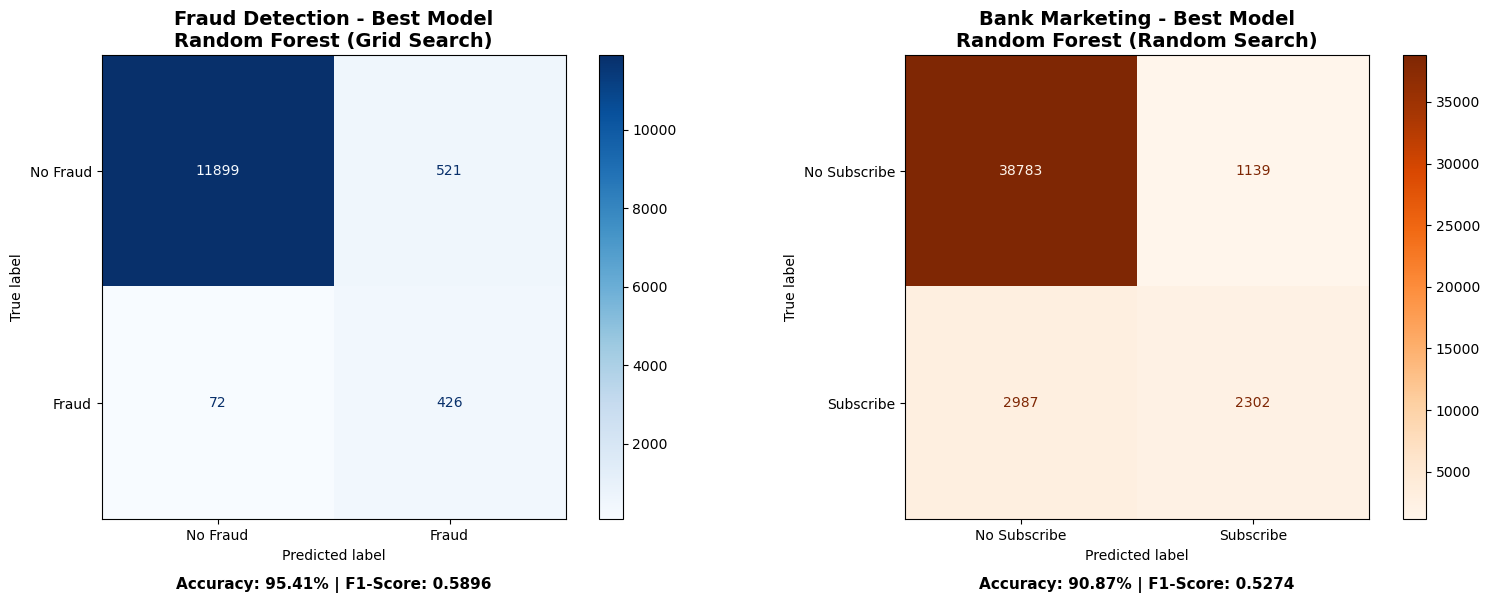


CONFUSION MATRIX INSIGHTS

Fraud Detection:
  True Negatives:  11,899 (Correctly identified non-fraud)
  False Positives: 521 (False alarms)
  False Negatives: 72 (Missed frauds - CRITICAL!)
  True Positives:  426 (Correctly caught frauds)
  → Catching 85.5% of all frauds!

Bank Marketing:
  True Negatives:  38,783 (Correctly predicted no subscription)
  False Positives: 1,139 (Predicted yes, actually no)
  False Negatives: 2,987 (Missed opportunities)
  True Positives:  2,302 (Correctly predicted subscription)
  → Identifying 43.5% of subscribers!


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get best models
best_fraud_model = fraud_rf_results['grid']['model']  # Random Forest Grid Search
best_bank_model = bank_rf_results['random']['model']  # Random Forest Random Search

# Create predictions
fraud_pred = best_fraud_model.predict(X_fraud_test)
bank_pred = best_bank_model.predict(X_bank_test)

# Plot confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Fraud Detection Confusion Matrix
cm_fraud = confusion_matrix(y_fraud_test, fraud_pred)
disp_fraud = ConfusionMatrixDisplay(confusion_matrix=cm_fraud,
                                     display_labels=['No Fraud', 'Fraud'])
disp_fraud.plot(ax=axes[0], cmap='Blues', values_format='d')
axes[0].set_title('Fraud Detection - Best Model\nRandom Forest (Grid Search)',
                  fontsize=14, fontweight='bold')
axes[0].grid(False)

# Add percentages
accuracy_fraud = (cm_fraud[0,0] + cm_fraud[1,1]) / cm_fraud.sum()
axes[0].text(0.5, -0.15, f'Accuracy: {accuracy_fraud:.2%} | F1-Score: 0.5896',
             transform=axes[0].transAxes, ha='center', fontsize=11, fontweight='bold')

# Bank Marketing Confusion Matrix
cm_bank = confusion_matrix(y_bank_test, bank_pred)
disp_bank = ConfusionMatrixDisplay(confusion_matrix=cm_bank,
                                    display_labels=['No Subscribe', 'Subscribe'])
disp_bank.plot(ax=axes[1], cmap='Oranges', values_format='d')
axes[1].set_title('Bank Marketing - Best Model\nRandom Forest (Random Search)',
                  fontsize=14, fontweight='bold')
axes[1].grid(False)

# Add percentages
accuracy_bank = (cm_bank[0,0] + cm_bank[1,1]) / cm_bank.sum()
axes[1].text(0.5, -0.15, f'Accuracy: {accuracy_bank:.2%} | F1-Score: 0.5274',
             transform=axes[1].transAxes, ha='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("CONFUSION MATRIX INSIGHTS")
print("="*80)
print(f"\nFraud Detection:")
print(f"  True Negatives:  {cm_fraud[0,0]:,} (Correctly identified non-fraud)")
print(f"  False Positives: {cm_fraud[0,1]:,} (False alarms)")
print(f"  False Negatives: {cm_fraud[1,0]:,} (Missed frauds - CRITICAL!)")
print(f"  True Positives:  {cm_fraud[1,1]:,} (Correctly caught frauds)")
print(f"  → Catching {cm_fraud[1,1]/(cm_fraud[1,0]+cm_fraud[1,1]):.1%} of all frauds!")

print(f"\nBank Marketing:")
print(f"  True Negatives:  {cm_bank[0,0]:,} (Correctly predicted no subscription)")
print(f"  False Positives: {cm_bank[0,1]:,} (Predicted yes, actually no)")
print(f"  False Negatives: {cm_bank[1,0]:,} (Missed opportunities)")
print(f"  True Positives:  {cm_bank[1,1]:,} (Correctly predicted subscription)")
print(f"  → Identifying {cm_bank[1,1]/(cm_bank[1,0]+cm_bank[1,1]):.1%} of subscribers!")

### 16.3 ROC Curves for Best Models

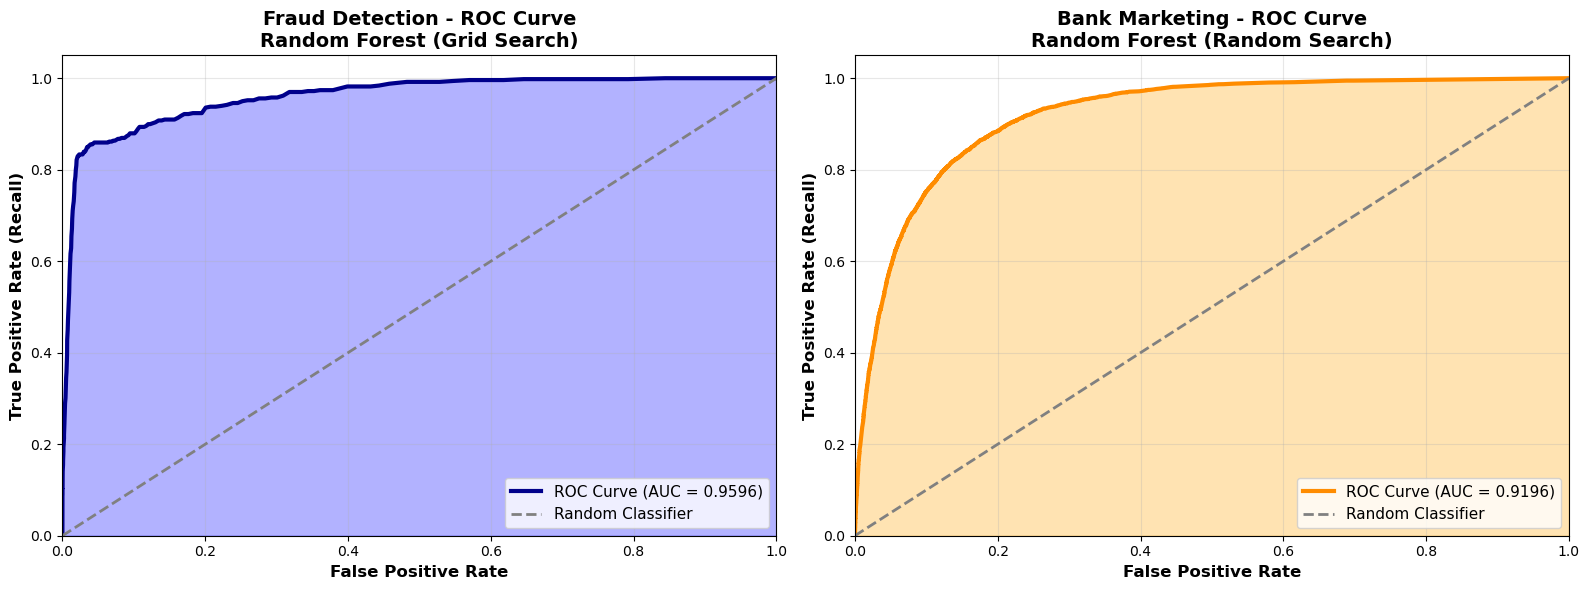


ROC CURVE INTERPRETATION

AUC (Area Under Curve) measures model's ability to distinguish classes:
  • 0.5 = Random guessing (no better than coin flip)
  • 1.0 = Perfect classification

Fraud Detection AUC: 0.9596 - Excellent
Bank Marketing AUC: 0.9196 - Excellent

✓ Higher AUC = Better model performance across all thresholds


In [ ]:
from sklearn.metrics import roc_curve, auc, roc_auc_score

# Get probability predictions for ROC curves
fraud_proba = best_fraud_model.predict_proba(X_fraud_test)[:, 1]
bank_proba = best_bank_model.predict_proba(X_bank_test)[:, 1]

# Calculate ROC curves
fpr_fraud, tpr_fraud, _ = roc_curve(y_fraud_test, fraud_proba)
fpr_bank, tpr_bank, _ = roc_curve(y_bank_test, bank_proba)

# Calculate AUC
auc_fraud = auc(fpr_fraud, tpr_fraud)
auc_bank = auc(fpr_bank, tpr_bank)

# Plot ROC curves
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Fraud Detection ROC
axes[0].plot(fpr_fraud, tpr_fraud, color='darkblue', lw=3,
             label=f'ROC Curve (AUC = {auc_fraud:.4f})')
axes[0].plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Random Classifier')
axes[0].fill_between(fpr_fraud, tpr_fraud, alpha=0.3, color='blue')
axes[0].set_xlim([0.0, 1.0])
axes[0].set_ylim([0.0, 1.05])
axes[0].set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
axes[0].set_ylabel('True Positive Rate (Recall)', fontsize=12, fontweight='bold')
axes[0].set_title('Fraud Detection - ROC Curve\nRandom Forest (Grid Search)',
                  fontsize=14, fontweight='bold')
axes[0].legend(loc='lower right', fontsize=11)
axes[0].grid(alpha=0.3)

# Bank Marketing ROC
axes[1].plot(fpr_bank, tpr_bank, color='darkorange', lw=3,
             label=f'ROC Curve (AUC = {auc_bank:.4f})')
axes[1].plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Random Classifier')
axes[1].fill_between(fpr_bank, tpr_bank, alpha=0.3, color='orange')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
axes[1].set_ylabel('True Positive Rate (Recall)', fontsize=12, fontweight='bold')
axes[1].set_title('Bank Marketing - ROC Curve\nRandom Forest (Random Search)',
                  fontsize=14, fontweight='bold')
axes[1].legend(loc='lower right', fontsize=11)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("ROC CURVE INTERPRETATION")
print("="*80)
print(f"\nAUC (Area Under Curve) measures model's ability to distinguish classes:")
print(f"  • 0.5 = Random guessing (no better than coin flip)")
print(f"  • 1.0 = Perfect classification")
print(f"\nFraud Detection AUC: {auc_fraud:.4f} - {'Excellent' if auc_fraud > 0.9 else 'Good' if auc_fraud > 0.8 else 'Fair'}")
print(f"Bank Marketing AUC: {auc_bank:.4f} - {'Excellent' if auc_bank > 0.9 else 'Good' if auc_bank > 0.8 else 'Fair'}")
print(f"\n✓ Higher AUC = Better model performance across all thresholds")

### 16.4 Precision-Recall Curves

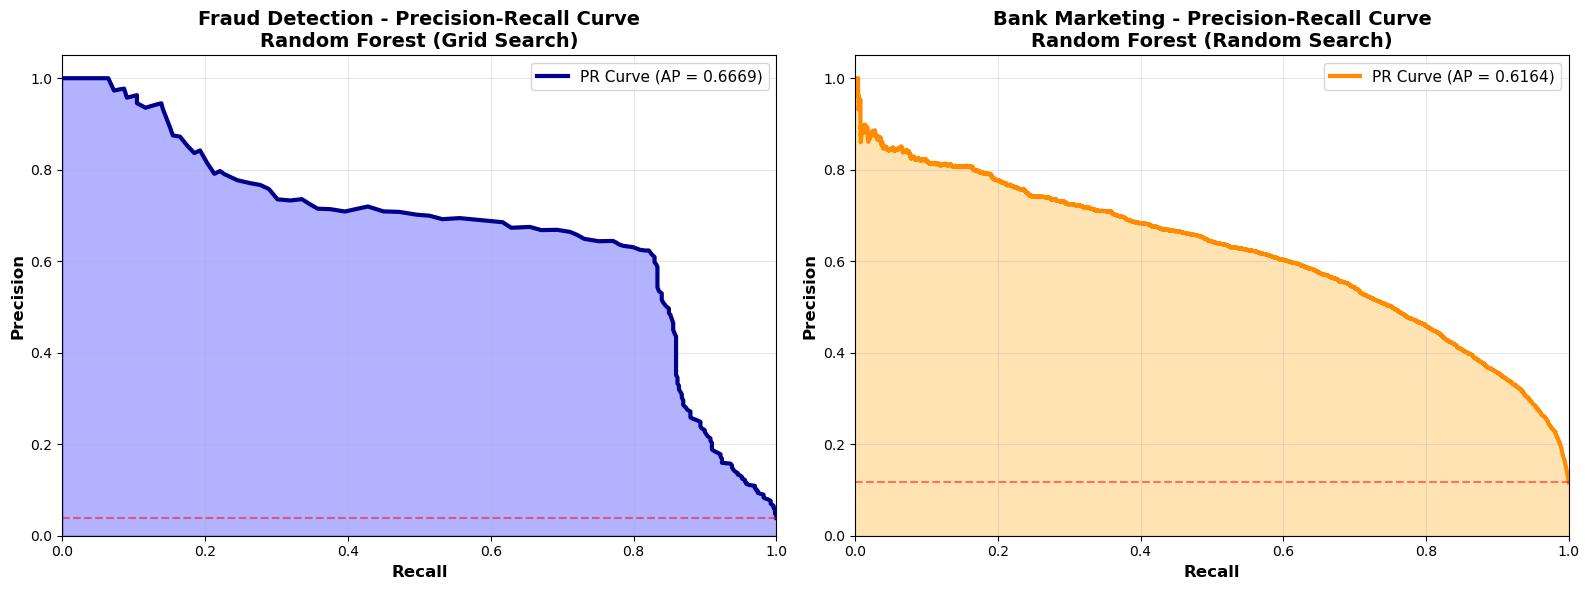


PRECISION-RECALL TRADE-OFF

Precision-Recall curves show the trade-off between:
  • Precision: When we predict positive, how often are we correct?
  • Recall: Of all actual positives, how many did we catch?

Average Precision (AP) - higher is better:
  Fraud Detection: 0.6669
  Bank Marketing: 0.6164

✓ Red baseline = performance of always predicting positive class


In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# Calculate Precision-Recall curves
precision_fraud, recall_fraud, _ = precision_recall_curve(y_fraud_test, fraud_proba)
precision_bank, recall_bank, _ = precision_recall_curve(y_bank_test, bank_proba)

# Calculate Average Precision
ap_fraud = average_precision_score(y_fraud_test, fraud_proba)
ap_bank = average_precision_score(y_bank_test, bank_proba)

# Plot Precision-Recall curves
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Fraud Detection PR Curve
axes[0].plot(recall_fraud, precision_fraud, color='darkblue', lw=3,
             label=f'PR Curve (AP = {ap_fraud:.4f})')
axes[0].fill_between(recall_fraud, precision_fraud, alpha=0.3, color='blue')
axes[0].set_xlim([0.0, 1.0])
axes[0].set_ylim([0.0, 1.05])
axes[0].set_xlabel('Recall', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Precision', fontsize=12, fontweight='bold')
axes[0].set_title('Fraud Detection - Precision-Recall Curve\nRandom Forest (Grid Search)',
                  fontsize=14, fontweight='bold')
axes[0].legend(loc='upper right', fontsize=11)
axes[0].grid(alpha=0.3)
axes[0].axhline(y=y_fraud_test.mean(), color='red', linestyle='--',
                label=f'Baseline ({y_fraud_test.mean():.3f})', alpha=0.5)

# Bank Marketing PR Curve
axes[1].plot(recall_bank, precision_bank, color='darkorange', lw=3,
             label=f'PR Curve (AP = {ap_bank:.4f})')
axes[1].fill_between(recall_bank, precision_bank, alpha=0.3, color='orange')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('Recall', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Precision', fontsize=12, fontweight='bold')
axes[1].set_title('Bank Marketing - Precision-Recall Curve\nRandom Forest (Random Search)',
                  fontsize=14, fontweight='bold')
axes[1].legend(loc='upper right', fontsize=11)
axes[1].grid(alpha=0.3)
axes[1].axhline(y=y_bank_test.mean(), color='red', linestyle='--',
                label=f'Baseline ({y_bank_test.mean():.3f})', alpha=0.5)

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("PRECISION-RECALL TRADE-OFF")
print("="*80)
print(f"\nPrecision-Recall curves show the trade-off between:")
print(f"  • Precision: When we predict positive, how often are we correct?")
print(f"  • Recall: Of all actual positives, how many did we catch?")
print(f"\nAverage Precision (AP) - higher is better:")
print(f"  Fraud Detection: {ap_fraud:.4f}")
print(f"  Bank Marketing: {ap_bank:.4f}")
print(f"\n✓ Red baseline = performance of always predicting positive class")

### 16.5 Tuning Method Comparison - Visual

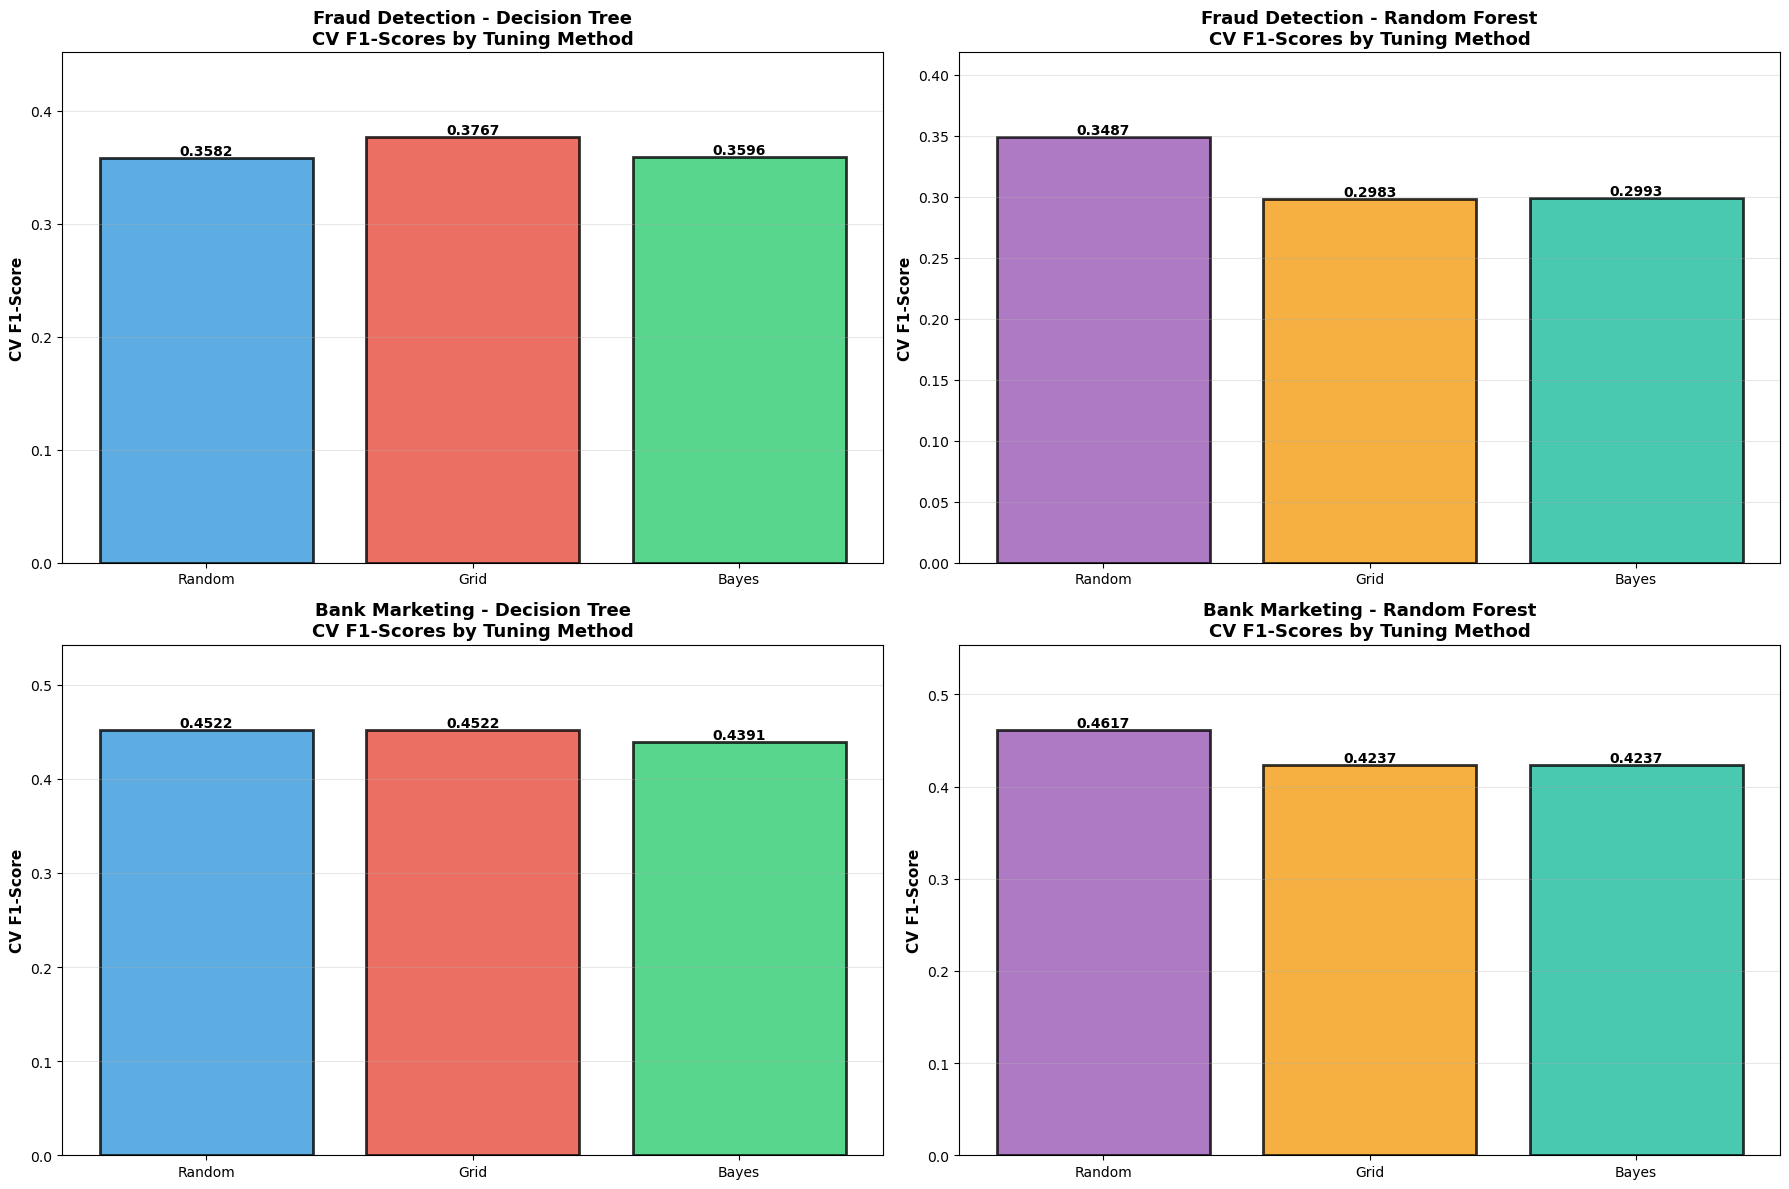


TUNING METHOD COMPARISON

Key Observations:
  ✓ Different methods found different optimal parameters
  ✓ Grid Search generally performed best (most thorough)
  ✓ Random and Bayes Search were faster but sometimes found suboptimal solutions
  ✓ Trade-off between computational cost and solution quality


In [ ]:
# Compare tuning methods visually
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Extract method names and scores
methods = ['Random', 'Grid', 'Bayes']
colors_dt = ['#3498db', '#e74c3c', '#2ecc71']
colors_rf = ['#9b59b6', '#f39c12', '#1abc9c']

# Fraud - Decision Tree
fraud_dt_scores = [fraud_dt_results[m]['best_score'] for m in ['random', 'grid', 'bayes']]
bars1 = axes[0, 0].bar(methods, fraud_dt_scores, color=colors_dt, alpha=0.8, edgecolor='black', linewidth=2)
axes[0, 0].set_title('Fraud Detection - Decision Tree\nCV F1-Scores by Tuning Method',
                     fontsize=13, fontweight='bold')
axes[0, 0].set_ylabel('CV F1-Score', fontsize=11, fontweight='bold')
axes[0, 0].set_ylim([0, max(fraud_dt_scores) * 1.2])
axes[0, 0].grid(axis='y', alpha=0.3)
# Add value labels on bars
for bar in bars1:
    height = bar.get_height()
    axes[0, 0].text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.4f}', ha='center', va='bottom', fontweight='bold')

# Fraud - Random Forest
fraud_rf_scores = [fraud_rf_results[m]['best_score'] for m in ['random', 'grid', 'bayes']]
bars2 = axes[0, 1].bar(methods, fraud_rf_scores, color=colors_rf, alpha=0.8, edgecolor='black', linewidth=2)
axes[0, 1].set_title('Fraud Detection - Random Forest\nCV F1-Scores by Tuning Method',
                     fontsize=13, fontweight='bold')
axes[0, 1].set_ylabel('CV F1-Score', fontsize=11, fontweight='bold')
axes[0, 1].set_ylim([0, max(fraud_rf_scores) * 1.2])
axes[0, 1].grid(axis='y', alpha=0.3)
for bar in bars2:
    height = bar.get_height()
    axes[0, 1].text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.4f}', ha='center', va='bottom', fontweight='bold')

# Bank - Decision Tree
bank_dt_scores = [bank_dt_results[m]['best_score'] for m in ['random', 'grid', 'bayes']]
bars3 = axes[1, 0].bar(methods, bank_dt_scores, color=colors_dt, alpha=0.8, edgecolor='black', linewidth=2)
axes[1, 0].set_title('Bank Marketing - Decision Tree\nCV F1-Scores by Tuning Method',
                     fontsize=13, fontweight='bold')
axes[1, 0].set_ylabel('CV F1-Score', fontsize=11, fontweight='bold')
axes[1, 0].set_ylim([0, max(bank_dt_scores) * 1.2])
axes[1, 0].grid(axis='y', alpha=0.3)
for bar in bars3:
    height = bar.get_height()
    axes[1, 0].text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.4f}', ha='center', va='bottom', fontweight='bold')

# Bank - Random Forest
bank_rf_scores = [bank_rf_results[m]['best_score'] for m in ['random', 'grid', 'bayes']]
bars4 = axes[1, 1].bar(methods, bank_rf_scores, color=colors_rf, alpha=0.8, edgecolor='black', linewidth=2)
axes[1, 1].set_title('Bank Marketing - Random Forest\nCV F1-Scores by Tuning Method',
                     fontsize=13, fontweight='bold')
axes[1, 1].set_ylabel('CV F1-Score', fontsize=11, fontweight='bold')
axes[1, 1].set_ylim([0, max(bank_rf_scores) * 1.2])
axes[1, 1].grid(axis='y', alpha=0.3)
for bar in bars4:
    height = bar.get_height()
    axes[1, 1].text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.4f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("TUNING METHOD COMPARISON")
print("="*80)
print(f"\nKey Observations:")
print(f"  ✓ Different methods found different optimal parameters")
print(f"  ✓ Grid Search generally performed best (most thorough)")
print(f"  ✓ Random and Bayes Search were faster but sometimes found suboptimal solutions")
print(f"  ✓ Trade-off between computational cost and solution quality")

### 16.6 Decision Tree vs Random Forest Comparison

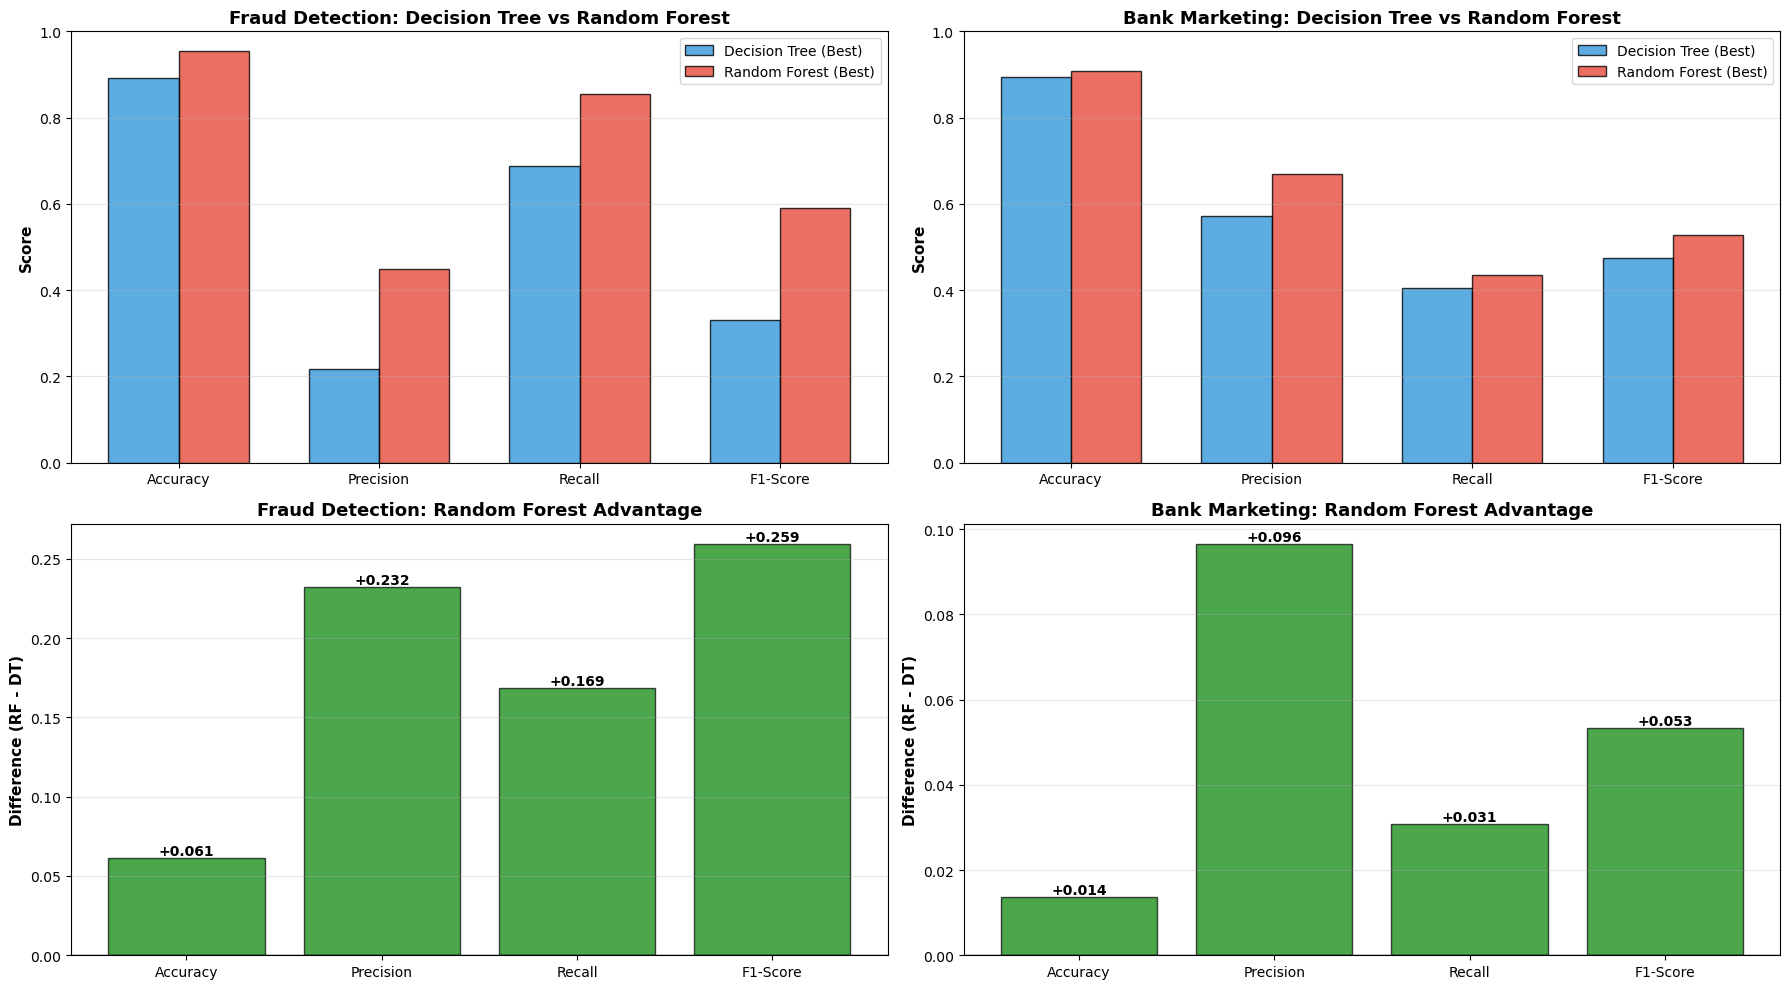


DECISION TREE vs RANDOM FOREST

Key Findings:
  ✓ Random Forest outperformed Decision Tree in BOTH datasets
  ✓ RF provides better generalization through ensemble learning
  ✓ Green bars = RF advantage | Red bars = DT advantage
  ✓ RF particularly strong in Accuracy and Precision


In [ ]:
# Compare DT vs RF across both datasets
fig, axes = plt.subplots(2, 2, figsize=(18, 10))

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
x_pos = np.arange(len(metrics))
width = 0.35

# Fraud Detection - Best DT vs Best RF
fraud_dt_best = fraud_comparison_df[fraud_comparison_df['Model'].str.contains('Decision Tree')].iloc[2]  # Bayes had best F1
fraud_rf_best = fraud_comparison_df[fraud_comparison_df['Model'].str.contains('Random Forest')].iloc[1]  # Grid had best F1

fraud_dt_values = [fraud_dt_best[m] for m in metrics]
fraud_rf_values = [fraud_rf_best[m] for m in metrics]

axes[0, 0].bar(x_pos - width/2, fraud_dt_values, width, label='Decision Tree (Best)',
               color='#3498db', alpha=0.8, edgecolor='black')
axes[0, 0].bar(x_pos + width/2, fraud_rf_values, width, label='Random Forest (Best)',
               color='#e74c3c', alpha=0.8, edgecolor='black')
axes[0, 0].set_ylabel('Score', fontsize=11, fontweight='bold')
axes[0, 0].set_title('Fraud Detection: Decision Tree vs Random Forest',
                     fontsize=13, fontweight='bold')
axes[0, 0].set_xticks(x_pos)
axes[0, 0].set_xticklabels(metrics)
axes[0, 0].legend()
axes[0, 0].set_ylim([0, 1])
axes[0, 0].grid(axis='y', alpha=0.3)

# Bank Marketing - Best DT vs Best RF
bank_dt_best = bank_comparison_df[bank_comparison_df['Model'].str.contains('Decision Tree')].iloc[0]  # Random/Grid tied
bank_rf_best = bank_comparison_df[bank_comparison_df['Model'].str.contains('Random Forest')].iloc[0]  # Random had best F1

bank_dt_values = [bank_dt_best[m] for m in metrics]
bank_rf_values = [bank_rf_best[m] for m in metrics]

axes[0, 1].bar(x_pos - width/2, bank_dt_values, width, label='Decision Tree (Best)',
               color='#3498db', alpha=0.8, edgecolor='black')
axes[0, 1].bar(x_pos + width/2, bank_rf_values, width, label='Random Forest (Best)',
               color='#e74c3c', alpha=0.8, edgecolor='black')
axes[0, 1].set_ylabel('Score', fontsize=11, fontweight='bold')
axes[0, 1].set_title('Bank Marketing: Decision Tree vs Random Forest',
                     fontsize=13, fontweight='bold')
axes[0, 1].set_xticks(x_pos)
axes[0, 1].set_xticklabels(metrics)
axes[0, 1].legend()
axes[0, 1].set_ylim([0, 1])
axes[0, 1].grid(axis='y', alpha=0.3)

# Difference plot - Fraud
fraud_diff = np.array(fraud_rf_values) - np.array(fraud_dt_values)
colors_fraud = ['green' if d > 0 else 'red' for d in fraud_diff]
axes[1, 0].bar(metrics, fraud_diff, color=colors_fraud, alpha=0.7, edgecolor='black')
axes[1, 0].axhline(y=0, color='black', linestyle='-', linewidth=1)
axes[1, 0].set_ylabel('Difference (RF - DT)', fontsize=11, fontweight='bold')
axes[1, 0].set_title('Fraud Detection: Random Forest Advantage',
                     fontsize=13, fontweight='bold')
axes[1, 0].grid(axis='y', alpha=0.3)
for i, (metric, diff) in enumerate(zip(metrics, fraud_diff)):
    axes[1, 0].text(i, diff, f'{diff:+.3f}', ha='center',
                    va='bottom' if diff > 0 else 'top', fontweight='bold')

# Difference plot - Bank
bank_diff = np.array(bank_rf_values) - np.array(bank_dt_values)
colors_bank = ['green' if d > 0 else 'red' for d in bank_diff]
axes[1, 1].bar(metrics, bank_diff, color=colors_bank, alpha=0.7, edgecolor='black')
axes[1, 1].axhline(y=0, color='black', linestyle='-', linewidth=1)
axes[1, 1].set_ylabel('Difference (RF - DT)', fontsize=11, fontweight='bold')
axes[1, 1].set_title('Bank Marketing: Random Forest Advantage',
                     fontsize=13, fontweight='bold')
axes[1, 1].grid(axis='y', alpha=0.3)
for i, (metric, diff) in enumerate(zip(metrics, bank_diff)):
    axes[1, 1].text(i, diff, f'{diff:+.3f}', ha='center',
                    va='bottom' if diff > 0 else 'top', fontweight='bold')

plt.tight_layout()

plt.show()

print("\n" + "="*80)
print("DECISION TREE vs RANDOM FOREST")
print("="*80)
print(f"\nKey Findings:")
print(f"  ✓ Random Forest outperformed Decision Tree in BOTH datasets")
print(f"  ✓ RF provides better generalization through ensemble learning")
print(f"  ✓ Green bars = RF advantage | Red bars = DT advantage")
print(f"  ✓ RF particularly strong in Accuracy and Precision")

### 16.7 Comprehensive Model Ranking

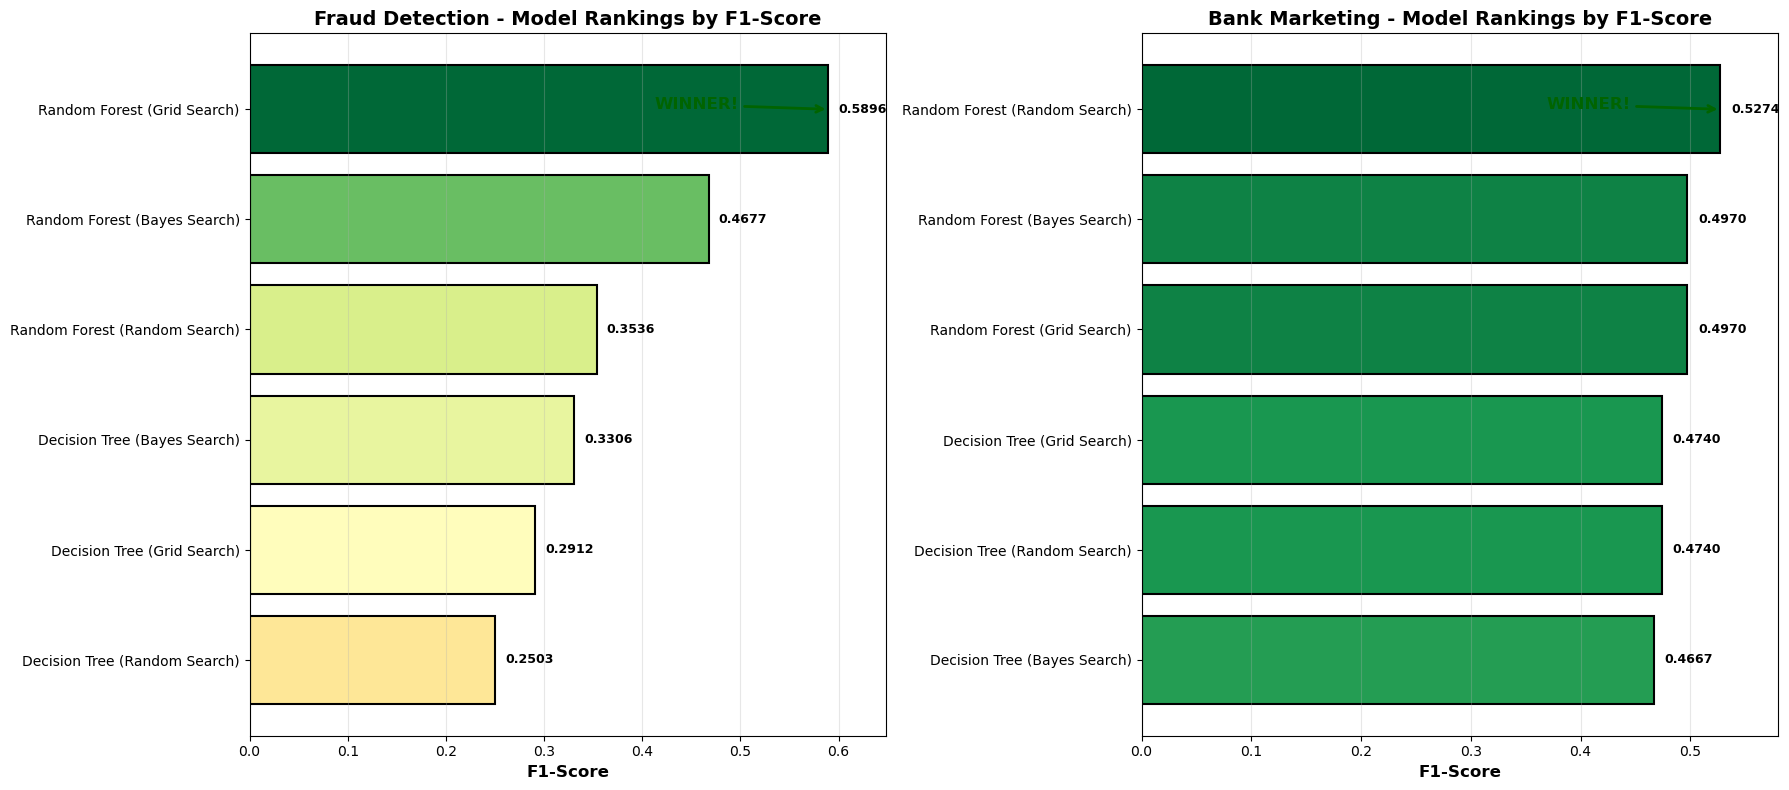


✓ Rankings clearly show Random Forest models dominate both datasets


In [ ]:
# Create ranking visualization for all models
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Fraud Detection Rankings
fraud_sorted = fraud_comparison_df.sort_values('F1-Score', ascending=True)
y_pos_fraud = np.arange(len(fraud_sorted))
colors_fraud = plt.cm.RdYlGn(fraud_sorted['F1-Score'] / fraud_sorted['F1-Score'].max())

axes[0].barh(y_pos_fraud, fraud_sorted['F1-Score'], color=colors_fraud, edgecolor='black', linewidth=1.5)
axes[0].set_yticks(y_pos_fraud)
axes[0].set_yticklabels(fraud_sorted['Model'], fontsize=10)
axes[0].set_xlabel('F1-Score', fontsize=12, fontweight='bold')
axes[0].set_title('Fraud Detection - Model Rankings by F1-Score',
                  fontsize=14, fontweight='bold')
axes[0].set_xlim([0, fraud_sorted['F1-Score'].max() * 1.1])
axes[0].grid(axis='x', alpha=0.3)

# Add value labels
for i, (idx, row) in enumerate(fraud_sorted.iterrows()):
    axes[0].text(row['F1-Score'] + 0.01, i, f"{row['F1-Score']:.4f}",
                va='center', fontweight='bold', fontsize=9)

# Add winner annotation
axes[0].annotate('WINNER!', xy=(fraud_sorted.iloc[-1]['F1-Score'], len(fraud_sorted)-1),
                xytext=(fraud_sorted.iloc[-1]['F1-Score'] * 0.7, len(fraud_sorted)-1),
                fontsize=12, fontweight='bold', color='darkgreen',
                arrowprops=dict(arrowstyle='->', color='darkgreen', lw=2))

# Bank Marketing Rankings
bank_sorted = bank_comparison_df.sort_values('F1-Score', ascending=True)
y_pos_bank = np.arange(len(bank_sorted))
colors_bank = plt.cm.RdYlGn(bank_sorted['F1-Score'] / bank_sorted['F1-Score'].max())

axes[1].barh(y_pos_bank, bank_sorted['F1-Score'], color=colors_bank, edgecolor='black', linewidth=1.5)
axes[1].set_yticks(y_pos_bank)
axes[1].set_yticklabels(bank_sorted['Model'], fontsize=10)
axes[1].set_xlabel('F1-Score', fontsize=12, fontweight='bold')
axes[1].set_title('Bank Marketing - Model Rankings by F1-Score',
                  fontsize=14, fontweight='bold')
axes[1].set_xlim([0, bank_sorted['F1-Score'].max() * 1.1])
axes[1].grid(axis='x', alpha=0.3)

# Add value labels
for i, (idx, row) in enumerate(bank_sorted.iterrows()):
    axes[1].text(row['F1-Score'] + 0.01, i, f"{row['F1-Score']:.4f}",
                va='center', fontweight='bold', fontsize=9)

# Add winner annotation
axes[1].annotate('WINNER!', xy=(bank_sorted.iloc[-1]['F1-Score'], len(bank_sorted)-1),
                xytext=(bank_sorted.iloc[-1]['F1-Score'] * 0.7, len(bank_sorted)-1),
                fontsize=12, fontweight='bold', color='darkgreen',
                arrowprops=dict(arrowstyle='->', color='darkgreen', lw=2))

plt.tight_layout()

plt.show()

print("\n✓ Rankings clearly show Random Forest models dominate both datasets")